In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
import yaml
def load_config(config_file):
    with open(config_file, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

In [119]:
from collections import namedtuple
config = load_config('settings/settings_detector_xwav_default.yaml')
# detParams = namedtuple('detParams', config.keys())(*config.values())
# detParams = DetParams(**config)
detParams = type('DetParams',(object,),config)()

In [120]:
from lib.wavio import *
from lib.functions import *
from lib.detection import *

In [121]:
dt_buildDirs(detParams)

In [122]:
fullFileNames = fn_findXWAVs(detParams.baseDir, 'x.wav')
fullLabels = fn_getFileset(detParams.metaDir, fullFileNames)
fullFileNames, fullLabels

(['/Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_020000.x.wav'],
 ['/Users/Jim/Documents/Project/WhaleClassification/output/2019-3-14_metadata/Arctic_C2_10_150728_020000.txt'])

In [123]:
currentRecFile = fullFileNames[0]
outFileName = fullLabels[0]
hdr = io_readXWavHeader(currentRecFile)
vars(hdr)

{'end': <lib.wavio.AnonymousClass at 0x119001d10>,
 'fType': 'xwav',
 'fs': 200000,
 'nBits': 16,
 'nch': 1,
 'raw': <lib.wavio.AnonymousClass at 0x118fc8e10>,
 'samp': <lib.wavio.AnonymousClass at 0x1181cc0d0>,
 'start': <lib.wavio.AnonymousClass at 0x118132a90>,
 'xgain': 1,
 'xhd': <lib.wavio.AnonymousClass at 0x118132510>}

In [124]:
startsSec, stopsSec = dt_chooseSegmentsRaw(hdr)
startsSec, stopsSec

(array([   0.        ,   75.00000001,  150.00000002,  225.00000003,
         300.00000003,  375.00000004,  450.00000005,  525.00000006,
         900.00000003,  975.00000003, 1050.00000004, 1125.00000005,
        1200.00000006, 1274.99999999, 1350.        , 1425.00000001,
        1800.00000005, 1875.00000006, 1949.99999999, 2025.        ,
        2100.00000001, 2175.00000002, 2250.00000003, 2325.00000003,
        2700.        , 2775.00000001, 2850.00000002, 2925.00000003,
        3000.00000003, 3075.00000004]),
 array([  74.99999506,  149.99999499,  224.999995  ,  299.99999501,
         374.99999501,  449.99999502,  524.99999503,  599.99999504,
         974.99999501, 1049.99999501, 1124.99999502, 1199.99999503,
        1274.99999504, 1349.99999505, 1424.99999506, 1499.99999499,
        1874.99999503, 1949.99999504, 2024.99999505, 2099.99999506,
        2174.99999499, 2249.999995  , 2324.99999501, 2399.99999501,
        2774.99999506, 2849.99999499, 2924.999995  , 2999.99999501,
        

In [125]:
previousFs, _ = fn_buildFilters(detParams, hdr.fs)
# detParams.previousFs = previousFs
params = fn_interp_tf(detParams)
if 'countThresh' not in vars(detParams) or detParams.countThresh == 0:
    detParams.countThresh = (10**((detParams.dBppThreshold - np.median(detParams.xfrOffset))/20))/2

--ends in *dt_batch* #57 ---

## Starts from here

In [126]:
from __future__ import division
import numpy as np
from scipy.signal import filtfilt
import time

cParams = dt_init_cParams(detParams) # set up storage for HR output.
sIdx = 0
# Open audio file
start = time.time()

with open(currentRecFile, 'r') as fh:
    buffSamples = int(detParams.LRbuffer*hdr.fs)
    # Loop through search area, running short term detectors
    detParams.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*
                                         np.array([detParams.delphClickDurLims[0]*.75,
                                         detParams.delphClickDurLims[1]*1.25])))
    for k in range(len(startsSec)):
        startK = startsSec[k]
        stopK = stopsSec[k]
        
        # [TODO] Read in data segment for WAV format
        dat = io_readRaw(fh, hdr, k, detParams.channel)
        
        # bandpass
        if detParams.filterSignal:
            padlen = 3*(max(len(detParams.fB),len(detParams.fA))-1)
            filtData = filtfilt(detParams.fB, detParams.fA, dat, padtype='odd', padlen=padlen)
        else:
            filtData = dat
        
        energy = filtData ** 2

        ### Run LR detection to identify candidates
        detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,detParams)
#         print detectionsSec
        for iD in range(len(detectionsSample)):
            # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
            filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
            clicks, noise = dt_HR(detParams, hdr, filtSegment)
            if len(clicks):
                # if we're in here, it's because we detected one or more possible
                # clicks in the kth segment of data
                # Make sure our click candidates aren't clipped
                validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)
                
                # Look at power spectrum of clicks, and remove those that don't
                # meet peak frequency and bandwidth requirements
                clicks = clicks[validClicks==1]
#                 print
                # Compute click parameters to decide if the detection should be kept
                clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                if len(clickDets.clickInd):
                    # populate cParams
                    cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                        detectionsSec[iD][0], hdr, sIdx, cParams)
print 'done with %s\n'%currentRecFile
end = time.time()
print round(end-start,2), ' s'

cParams = dt_prune_cParams(cParams,sIdx)

# Run post processing to remove rogue loner clicks, prior to writing
# the remaining output files.
clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

encounterTimes = []

keepFlag = dt_postproc(outFileName,clickTimes,params,hdr,encounterTimes)
keepIdx = np.where(keepFlag==1)[0]

baseFileName = os.path.splitext(outFileName)[0]
fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_020000.x.wav

17.48  s


1. difference in butter function
2. difference in filtfilt

## Verbose

In [114]:
from __future__ import division
import numpy as np
from scipy.signal import filtfilt
import time

timecosts = list()
start = time.time()

cParams = dt_init_cParams(detParams) # set up storage for HR output.
sIdx = 0
# Open audio file
with open(currentRecFile, 'r') as fh:
    buffSamples = int(detParams.LRbuffer*hdr.fs)
    # Loop through search area, running short term detectors
    detParams.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*\
                                         np.array([detParams.delphClickDurLims[0]*.75,\
                                         detParams.delphClickDurLims[1]*1.25])))
    loop = start
    for k in range(len(startsSec)):
        timecost = list()
        loop = time.time()
        
        startK = startsSec[k]
        stopK = stopsSec[k]

        # [TODO] Read in data segment for WAV format
        ts = time.time()
        dat = io_readRaw(fh, hdr, k, detParams.channel)
        print 'reading data costs', round(time.time() - ts,2)
        timecost.append(round(time.time() - ts,2))
        
        ts = time.time()
        # bandpass
        if detParams.filterSignal:
            padlen = 3*(max(len(detParams.fB),len(detParams.fA))-1)
            filtData = filtfilt(detParams.fB, detParams.fA, dat, padtype='odd', padlen=padlen)
        else:
            filtData = dat
        print 'filtData costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        energy = filtData ** 2
        
        ### Run LR detection to identify candidates
        ts = time.time()
        detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,detParams)
        print 'lr costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        # [2/9]
        # [FUTURE] PARALLEL in detectionsSample
        ts = time.time()
        for iD in range(len(detectionsSample)):
            # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
            filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
            clicks, noise = dt_HR(detParams, hdr, filtSegment)
            if len(clicks):
                # if we're in here, it's because we detected one or more possible
                # clicks in the kth segment of data
                # Make sure our click candidates aren't clipped
                validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)

                # Look at power spectrum of clicks, and remove those that don't
                # meet peak frequency and bandwidth requirements
                clicks = clicks[validClicks==1]
                # Compute click parameters to decide if the detection should be kept
                clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                if len(clickDets.clickInd):
                    # populate cParams
                    cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                        detectionsSec[iD][0], hdr, sIdx, cParams)
        print 'hl costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        print round(time.time() - loop, 2)
        timecost.append(round(time.time() - loop,2))
        
        timecosts.append(timecost)
        
print 'done with %s\n'%currentRecFile
end = time.time()
print round(end-start,2), ' s'

cParams = dt_prune_cParams(cParams,sIdx)

# Run post processing to remove rogue loner clicks, prior to writing
# the remaining output files.
clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

# keepFlag = dt_postproc(outFileName,clickTimes,p,hdr,encounterTimes)
# keepIdx = np.where[keepFlag==1]

baseFileName = os.path.splitext(outFileName)[0]
fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

reading data costs 0.08
filtData costs 0.29
lr costs 0.03
hl costs 0.0
0.45
reading data costs 0.08
filtData costs 0.31
lr costs 0.04
hl costs 0.0
0.48
reading data costs 0.08
filtData costs 0.29
lr costs 0.03
hl costs 0.0
0.43
reading data costs 0.08
filtData costs 0.27
lr costs 0.02
hl costs 0.0
0.4
reading data costs 0.08
filtData costs 0.29
lr costs 0.02
hl costs 0.0
0.45
reading data costs 0.08
filtData costs 0.3
lr costs 0.02
hl costs 0.03
0.46
reading data costs 0.09
filtData costs 0.32
lr costs 0.02
hl costs 0.0
0.48
reading data costs 0.09
filtData costs 0.3
lr costs 0.02
hl costs 0.01
0.46
reading data costs 0.08
filtData costs 0.3
lr costs 0.02
hl costs 0.0
0.45
reading data costs 0.08
filtData costs 0.28
lr costs 0.02
hl costs 0.0
0.41
reading data costs 0.08
filtData costs 0.3
lr costs 0.02
hl costs 0.0
0.43
reading data costs 0.08
filtData costs 0.29
lr costs 0.02
hl costs 0.01
0.44
reading data costs 0.08
filtData costs 0.27
lr costs 0.02
hl costs 0.0
0.4
reading data co

Text(0.5,0,'samples')

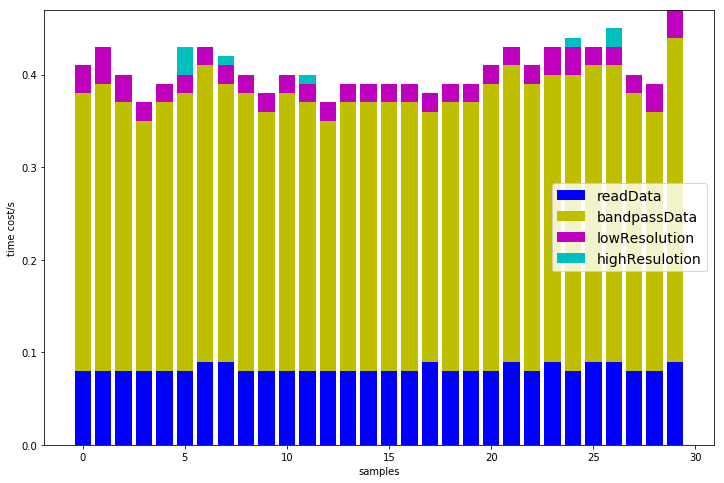

In [115]:
import matplotlib.pyplot as plt
timecosts = np.array(timecosts)
timecosts.shape
plt.figure(figsize=(12, 8))
legends = ['readData', 'bandpassData', 'lowResolution', 'highResulotion', 'total']
X = np.arange(timecosts.shape[0])
plt.bar(X,timecosts[:,0], label=legends[0], color='blue')
plt.bar(X,timecosts[:,1], bottom=timecosts[:,0],label=legends[1], color='y')
plt.bar(X,timecosts[:,2], bottom=timecosts[:,0]+timecosts[:,1],label=legends[2], color='m')
plt.bar(X,timecosts[:,3], bottom=timecosts[:,0]+timecosts[:,1]+timecosts[:,2],label=legends[3], color='c')
# for i in range(timecosts.shape[1]-1):
#     if i > 0:
#         bottom = [timecosts[:,i-1]
#         plt.bar(X,timecosts[:,i], bottom=timecosts[:,i-1], label=legends[i])
#     else:
#         plt.bar(X,timecosts[:,i], label=legends[i])
# i = 4
# plt.plot(timecosts[:,i], label=legends[i], '--')
plt.legend(prop={'size': 14})
plt.ylabel('time cost/s')
plt.xlabel('samples')

1. 15s
2. 15s
3. 21s

1. improve through multi-core/multi-processor
2. improve code optimization, filter optimization
3. use pre-filtering

([<matplotlib.patches.Wedge at 0x117f99cd0>,
 [Text(-0.984234,0.491207,'ReadData'),
  Text(0.736312,-0.947547,'BandPass'),
  Text(0.230654,1.07555,'LR'),
  Text(0.0368929,1.09938,'HR'),
  Text(-0.276428,1.0647,'Others')],
 [Text(-0.536855,0.267931,'18.60%'),
  Text(0.429515,-0.552736,'67.16%'),
  Text(0.125811,0.586661,'5.08%'),
  Text(0.0201234,0.599662,'0.57%'),
  Text(-0.150779,0.580746,'8.58%')])

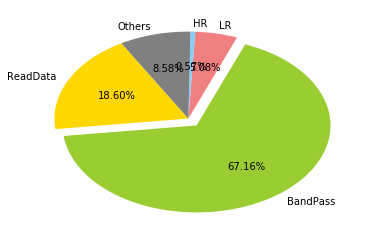

In [116]:
import matplotlib.pyplot as plt
costs = np.copy(timecosts)
costs[:,4] = timecosts[:,4]-np.sum(timecosts[:,:4],axis=1)
# plt.figure(figsize=(12, 8))
costs = costs/np.sum(costs,axis=1).reshape(-1,1)

labels = ['ReadData', 'BandPass', 'LR', 'HR', 'Others']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'grey']
explode = (0, 0.1, 0, 0, 0)
plt.pie(np.mean(costs,axis=0), explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', startangle=120)

## Multiple-files

In [77]:
import time
def dt_batch(fullFiles, fullLabels, detParams, encounterTimes, runMode):

    N = len(fullFiles)
    detParams.previousFs = 0 # make sure we build filters on first pass

    # get file type list
    # fTypes = io_getFileType(fullFiles);

    for idx1 in range(N): # for each data file
        
        timecosts = list()
        
        params = detParams
        
        currentRecFile = fullFileNames[idx1]
        outFileName = fullLabels[idx1]
        print 'beginning file %d of %d \n' % (idx1, N)
        start = time.time()

        # read file header
        hdr = io_readXWavHeader(currentRecFile)

        # [TODO] extend options for wav files
        # divide xwav by raw file
        startsSec, stopsSec = dt_chooseSegmentsRaw(hdr)

        if hdr.fs != params.previousFs:
            # otherwise, if this is the first time through, build your filters,
            # only need to do this once though, so if you already have this
            # info, this step is skipped
            
            previousFs, _ = fn_buildFilters(params, hdr.fs)
            params.previousFs = previousFs;
            params = fn_interp_tf(params)
            if 'countThresh' not in vars(params) or params.countThresh == 0:
                params.countThresh = (10**((params.dBppThreshold - np.median(params.xfrOffset))/20))/2

        cParams = dt_init_cParams(params) # set up storage for HR output.
        sIdx = 0

        # Open audio file
        with open(currentRecFile, 'r') as fh:
            buffSamples = int(params.LRbuffer*hdr.fs)
            # Loop through search area, running short term detectors
            params.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*\
                                                 np.array([params.delphClickDurLims[0]*.75,\
                                                 params.delphClickDurLims[1]*1.25])))
            for k in range(len(startsSec)):
                
                startK = startsSec[k]
                stopK = stopsSec[k]

                # [TODO] Read in data segment for WAV format
                dat = io_readRaw(fh, hdr, k, params.channel)
                
                # bandpass
                if params.filterSignal:
                    padlen = 3*(max(len(params.fB),len(params.fA))-1)
                    filtData = filtfilt(params.fB, params.fA, dat, padtype='odd', padlen=padlen)
                else:
                    filtData = dat
                
                energy = filtData ** 2
                
                ### Run LR detection to identify candidates
                ts = time.time()
                detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,params)
                
                # [2/9]
                # [FUTURE] PARALLEL in detectionsSample
                ts = time.time()
                for iD in range(len(detectionsSample)):
                    # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
                    filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
                    clicks, noise = dt_HR(params, hdr, filtSegment)
                    if len(clicks):
                        # if we're in here, it's because we detected one or more possible
                        # clicks in the kth segment of data
                        # Make sure our click candidates aren't clipped
                        validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)

                        # Look at power spectrum of clicks, and remove those that don't
                        # meet peak frequency and bandwidth requirements
                        clicks = clicks[validClicks==1]
                        # Compute click parameters to decide if the detection should be kept
                        clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                        if len(clickDets.clickInd):
                            # populate cParams
                            cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                                detectionsSec[iD][0], hdr, sIdx, cParams)
        
        print 'done with %s\n'%currentRecFile
        end = time.time()
        print round(end-start,2), ' s\n\n'

        cParams = dt_prune_cParams(cParams,sIdx)

        # Run post processing to remove rogue loner clicks, prior to writing
        # the remaining output files.
        clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

        encounterTimes = []

        keepFlag = dt_postproc(outFileName,clickTimes,params,hdr,encounterTimes)
        keepIdx = np.where(keepFlag==1)[0]

        baseFileName = os.path.splitext(outFileName)[0]
        fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

In [79]:
warnings.filterwarnings("ignore")

# parser = argparse.ArgumentParser(description='spice_detector')
# parser.add_argument('-s', '--setting', action='store', required=True, dest='detParamsFile', help='detector settings file', type=str)
# args = vars(parser.parse_args())

runMode = 'batchRun' # default to batch. Need to implement guiRun.
# config = load_config(args['detParamsFile'])
config = load_config('settings/settings_detector_xwav_default.yaml')
detParams = type('DetParams',(object,),config)()

detParams = dt_buildDirs(detParams)

# Build list of (x)wav names in the base directory.
# Right now only wav and xwav files are looked for.
fullFileNames = fn_findXWAVs(detParams.baseDir, 'x.wav')

encounterTimes = list()

# return a list of files to be built
fullLabels = fn_getFileset(detParams.metaDir, fullFileNames)

if len(fullFileNames):
    print 'Beginning detection\n\n'
    dt_batch(fullFileNames,fullLabels,detParams,encounterTimes,runMode)
else:
    print 'Error: No wav/xwav files found'

Beginning detection


beginning file 0 of 4 

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_160423_033000.x.wav

13.26  s


beginning file 1 of 4 

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_010230.x.wav

18.17  s


beginning file 2 of 4 

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_150728_020000.x.wav

15.57  s


beginning file 3 of 4 

done with /Users/Jim/Documents/Project/WhaleClassification/WAT_NC_01/Arctic_C2_10_160423_090500.x.wav

12.83  s




## Lfilter

In [127]:

from __future__ import division
import numpy as np
from scipy.signal import filtfilt
from scipy.signal import lfilter
import time

timecosts = list()
start = time.time()

cParams = dt_init_cParams(detParams) # set up storage for HR output.
sIdx = 0
# Open audio file
with open(currentRecFile, 'r') as fh:
    buffSamples = int(detParams.LRbuffer*hdr.fs)
    # Loop through search area, running short term detectors
    detParams.clickSampleLims = np.int64(np.ceil((hdr.fs/10**6)*\
                                         np.array([detParams.delphClickDurLims[0]*.75,\
                                         detParams.delphClickDurLims[1]*1.25])))
    loop = start
    for k in range(len(startsSec)):
        timecost = list()
        loop = time.time()
        
        startK = startsSec[k]
        stopK = stopsSec[k]

        # [TODO] Read in data segment for WAV format
        ts = time.time()
        dat = io_readRaw(fh, hdr, k, detParams.channel)
        print 'reading data costs', round(time.time() - ts,2)
        timecost.append(round(time.time() - ts,2))
        
        ts = time.time()
        # bandpass
        if detParams.filterSignal:
            padlen = 3*(max(len(detParams.fB),len(detParams.fA))-1)
            filtData = lfilter(detParams.fB, detParams.fA, dat)
        else:
            filtData = dat
        print 'filtData costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        energy = filtData ** 2
        
        ### Run LR detection to identify candidates
        ts = time.time()
        detectionsSample,detectionsSec =  dt_LR(energy,hdr,buffSamples,startK,stopK,detParams)
        print 'lr costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        # [2/9]
        # [FUTURE] PARALLEL in detectionsSample
        ts = time.time()
        for iD in range(len(detectionsSample)):
            # [FUTURE] HOW TO EXTRACT SUBARRAY FROM NP ARRAY WITH DIFFERENT LENGTH
            filtSegment = filtData[detectionsSample[iD][0]:detectionsSample[iD][1]+1]
            clicks, noise = dt_HR(detParams, hdr, filtSegment)
            if len(clicks):
                # if we're in here, it's because we detected one or more possible
                # clicks in the kth segment of data
                # Make sure our click candidates aren't clipped
                validClicks = dt_pruneClipping(clicks, params, hdr, filtSegment)

                # Look at power spectrum of clicks, and remove those that don't
                # meet peak frequency and bandwidth requirements
                clicks = clicks[validClicks==1]
                # Compute click parameters to decide if the detection should be kept
                clickDets,f = dt_parameters(noise, filtSegment, params, clicks, hdr)
                if len(clickDets.clickInd):
                    # populate cParams
                    cParams, sIdx = dt_populate_cParams(clicks, params, clickDets,
                                                        detectionsSec[iD][0], hdr, sIdx, cParams)
        print 'hl costs', round(time.time() - ts, 2)
        timecost.append(round(time.time() - ts,2))
        
        print round(time.time() - loop, 2)
        timecost.append(round(time.time() - loop,2))
        
        timecosts.append(timecost)
        
print 'done with %s\n'%currentRecFile
end = time.time()
print round(end-start,2), ' s'

cParams = dt_prune_cParams(cParams,sIdx)

# Run post processing to remove rogue loner clicks, prior to writing
# the remaining output files.
clickTimes = cParams.clickTimes[cParams.clickTimes[:,0].argsort()]

# keepFlag = dt_postproc(outFileName,clickTimes,p,hdr,encounterTimes)
# keepIdx = np.where[keepFlag==1]

baseFileName = os.path.splitext(outFileName)[0]
fn_saveDets2pkl(baseFileName+'.pkl',cParams,f,hdr,params)

reading data costs 0.06
filtData costs 0.14
lr costs 0.02
hl costs 0.2
0.44
reading data costs 0.06
filtData costs 0.14
lr costs 0.03
hl costs 0.06
0.32
reading data costs 0.05
filtData costs 0.13
lr costs 0.02
hl costs 0.05
0.29
reading data costs 0.05
filtData costs 0.13
lr costs 0.02
hl costs 0.04
0.28
reading data costs 0.05
filtData costs 0.13
lr costs 0.01
hl costs 0.05
0.33
reading data costs 0.07
filtData costs 0.14
lr costs 0.02
hl costs 0.05
0.36
reading data costs 0.06
filtData costs 0.14
lr costs 0.03
hl costs 0.05
0.33
reading data costs 0.05
filtData costs 0.14
lr costs 0.03
hl costs 0.07
0.34
reading data costs 0.06
filtData costs 0.14
lr costs 0.02
hl costs 0.05
0.31
reading data costs 0.05
filtData costs 0.13
lr costs 0.03
hl costs 0.07
0.32
reading data costs 0.07
filtData costs 0.14
lr costs 0.02
hl costs 0.08
0.35
reading data costs 0.05
filtData costs 0.13
lr costs 0.03
hl costs 0.05
0.3
reading data costs 0.07
filtData costs 0.14
lr costs 0.02
hl costs 0.06
0.34
r